In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Tugas UTS***

Metode CNN (Convolutional Neural Network) untuk klasifikasi citra antara 2 gaya arsitektur bangunan yaitu Baroque dan Modernist. Gaya arsitektur Baroque adalah gaya arsitektur yang dikenal dengan detail ornamen yang rumit, elemen artistik yang mewah, dan dekorasi yang dramatis. Sedangkan gaya arsitektur Modernist adalah gaya arsitektur yang lebih minimalis, fokus pada fungsi, penggunaan bahan modern, dan estetika geometris. Diharapkan metode CNN dapat mengidentifikasikan sebuah citra bangunan termasuk kedalam gaya arsitektur banguna baroque atau Modernist.

Dataset yang digunakan adalah dataset arsitektur bangunan yaitu Architectural Styles Periods Dataset yang tersedia di Kaggle milik Gustavo A Chavez.
Link : https://www.kaggle.com/datasets/gustavoachavez/architectural-styles-periods-dataset/data

Dataset ini berisi gambar-gambar arsitektur yang dikategorikan berdasarkan gaya arsitektur, terdapat beberapa class namun untuk project ini diambil 2 class saja yaitu:

Baroque: Gaya arsitektur dengan ornamen rumit dan dramatis.

Modernist: Gaya arsitektur dengan pendekatan minimalis dan penggunaan bentuk geometris.

Jumlah Data Awal:

Baroque: 1079 gambar.

Modernist: 1867 gambar.

Masalah Data: Dataset tidak seimbang (imbalance data) karena jumlah gambar class Modernist lebih banyak dibandingkan class Baroque.


Dilakukan 2 pendekatan untuk mengatasi masalah data yang imbalace.

Pendekatan Preprocessing:

Pendekatan 1: Menyamakan jumlah data kedua class (Baroque dan Modernist) menjadi 1079 gambar (class Baroque dengan dataset terkecil) dengan pengambilan sampel acak dari class Modernist.

Pendekatan 2: Membiarkan jumlah data Modernist tetap lebih banyak pada data training, kemudian melakukan proses augmentasi pada data training untuk class Baroque. Dengan data validation dan data testing seiimbang untuk kedua class tanpa proses augmentasi.


# Pendekatan 1: Sampling dataset modernist

In [ ]:
import os
import random
import shutil

# Path dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/ArchitecturalStylesDataset'
balanced_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/BalancedSampleDataset'

# Membuat direktori baru untuk balanced dataset
os.makedirs(balanced_dataset_path, exist_ok=True)
for class_name in ['Baroque', 'Modernist']:
    os.makedirs(os.path.join(balanced_dataset_path, class_name), exist_ok=True)

# Fungsi untuk menyalin data ke folder baru
def balance_by_sampling(original_dir, target_dir, max_samples):
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)

        if class_name == 'Modernist':
            # Sampling acak sejumlah max_samples
            sampled_files = random.sample(os.listdir(class_dir), max_samples)
        else:
            # Salin semua file Baroque
            sampled_files = os.listdir(class_dir)

        for file in sampled_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(target_class_dir, file)
            shutil.copy(src, dst)

# Menyeimbangkan data dengan sampling
balance_by_sampling(dataset_path, balanced_dataset_path, max_samples=1079)


splitting dataset

In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Path balanced dataset
balanced_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/BalancedSampleDataset'
splitted_dataset_path_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset'

# Membuat direktori untuk train, val, test
for split in ['train', 'val', 'test']:
    for class_name in ['Baroque', 'Modernist']:
        os.makedirs(os.path.join(splitted_dataset_path_1, split, class_name), exist_ok=True)

# Fungsi untuk splitting dataset
def split_dataset_balanced(original_dir, target_dir, train_ratio=0.7, val_ratio=0.2):
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        images = os.listdir(class_dir)

        # Split data
        train, temp = train_test_split(images, test_size=1 - train_ratio, random_state=42)
        val, test = train_test_split(temp, test_size=(1 - train_ratio - val_ratio) / (1 - train_ratio), random_state=42)

        # Copy data ke folder target
        for split, split_name in zip([train, val, test], ['train', 'val', 'test']):
            target_class_dir = os.path.join(target_dir, split_name, class_name)
            for file in split:
                src = os.path.join(class_dir, file)
                dst = os.path.join(target_class_dir, file)
                shutil.copy(src, dst)

# Splitting dataset
split_dataset_balanced(balanced_dataset_path, splitted_dataset_path_1)


verifikasi

In [ ]:
import os

splitted_dataset_path_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset'

def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Verifikasi jumlah data
train_counts_1 = count_images(os.path.join(splitted_dataset_path_1, 'train'))
val_counts_1 = count_images(os.path.join(splitted_dataset_path_1, 'val'))
test_counts_1 = count_images(os.path.join(splitted_dataset_path_1, 'test'))

print("Pendekatan 1 - Training Counts:", train_counts_1)
print("Pendekatan 1 - Validation Counts:", val_counts_1)
print("Pendekatan 1 - Testing Counts:", test_counts_1)


Pendekatan 1 - Training Counts: {'Baroque': 755, 'Modernist': 755}
Pendekatan 1 - Validation Counts: {'Baroque': 215, 'Modernist': 215}
Pendekatan 1 - Testing Counts: {'Baroque': 109, 'Modernist': 109}


normalisasi dan augmentasi

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke train, val, test
train_dir_1 = os.path.join(splitted_dataset_path_1, 'train')
val_dir_1 = os.path.join(splitted_dataset_path_1, 'val')
test_dir_1 = os.path.join(splitted_dataset_path_1, 'test')

# Data augmentation untuk training, hanya rescaling untuk validation dan testing
train_datagen_1 = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen_1 = ImageDataGenerator(rescale=1.0/255)

# Load dataset
train_data_1 = train_datagen_1.flow_from_directory(
    train_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data_1 = val_test_datagen_1.flow_from_directory(
    val_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data_1 = val_test_datagen_1.flow_from_directory(
    test_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1510 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


# Pendekatan 2: augemented dataset baroque

In [ ]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
from datetime import datetime

# Path dataset asli
original_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/ArchitecturalStylesDataset'
splitted_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset'

# Buat direktori untuk train, val, test
for split in ['train', 'val', 'test']:
    for class_name in ['Baroque', 'Modernist']:
        os.makedirs(os.path.join(splitted_dataset_path, split, class_name), exist_ok=True)

# Fungsi untuk splitting dataset dengan balancing untuk validation dan testing
def split_and_balance_dataset(original_dir, target_dir, train_ratio=0.7, val_ratio=0.2):
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        images = os.listdir(class_dir)

        # Split data ke train, val, dan test
        train, temp = train_test_split(images, test_size=1 - train_ratio, random_state=42)
        val, test = train_test_split(temp, test_size=(1 - train_ratio - val_ratio) / (1 - train_ratio), random_state=42)

        # Pastikan validation dan testing seimbang
        if class_name == "Modernist":
            baroque_val_dir = os.path.join(target_dir, 'val', 'Baroque')
            baroque_test_dir = os.path.join(target_dir, 'test', 'Baroque')
            baroque_val_count = len(os.listdir(baroque_val_dir))
            baroque_test_count = len(os.listdir(baroque_test_dir))

            # Sampling ulang untuk validation dan testing Modernist
            val = random.sample(val, baroque_val_count)
            test = random.sample(test, baroque_test_count)

        # Copy data ke folder target
        for split, split_name in zip([train, val, test], ['train', 'val', 'test']):
            target_class_dir = os.path.join(target_dir, split_name, class_name)
            for file in split:
                src = os.path.join(class_dir, file)
                dst = os.path.join(target_class_dir, file)
                shutil.copy(src, dst)

# Split dataset dan pastikan validation dan testing seimbang
split_and_balance_dataset(original_dataset_path, splitted_dataset_path)

# Augmentasi hanya untuk data training kelas Baroque
augment_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_training_data(class_dir, target_count):
    images = os.listdir(class_dir)
    num_images = len(images)
    required_augments = target_count - num_images
    image_idx = 0

    while required_augments > 0:
        img_path = os.path.join(class_dir, images[image_idx % num_images])
        img = Image.open(img_path)
        img = img.resize((128, 128))
        img = np.expand_dims(np.array(img), 0)

        for batch in augment_gen.flow(
            img,
            batch_size=1,
            save_to_dir=class_dir,
            save_prefix=f'aug_{datetime.now().strftime("%Y%m%d%H%M%S")}',
            save_format='jpeg'
        ):
            required_augments -= 1
            if required_augments <= 0:
                break
        image_idx += 1

# Augmentasi untuk data training Baroque
baroque_train_dir = os.path.join(splitted_dataset_path, 'train', 'Baroque')
modernist_train_dir = os.path.join(splitted_dataset_path, 'train', 'Modernist')

# Pastikan jumlah data train kelas seimbang
target_train_count = len(os.listdir(modernist_train_dir))  # Gunakan jumlah data Modernist
augment_training_data(baroque_train_dir, target_count=target_train_count)


verifikasi dataset augmented

In [ ]:
import os

splitted_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset'

def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# Verifikasi jumlah data
train_counts_2 = count_images(os.path.join(splitted_dataset_path, 'train'))
val_counts_2 = count_images(os.path.join(splitted_dataset_path, 'val'))
test_counts_2 = count_images(os.path.join(splitted_dataset_path, 'test'))

print("Pendekatan 2 - Training Counts:", train_counts_2)
print("Pendekatan 2 - Validation Counts:", val_counts_2)
print("Pendekatan 2 - Testing Counts:", test_counts_2)


Pendekatan 2 - Training Counts: {'Baroque': 1286, 'Modernist': 1306}
Pendekatan 2 - Validation Counts: {'Baroque': 215, 'Modernist': 215}
Pendekatan 2 - Testing Counts: {'Baroque': 109, 'Modernist': 109}


normalisasi dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke train, val, test
train_dir_2 = os.path.join(splitted_dataset_path, 'train')
val_dir_2 = os.path.join(splitted_dataset_path, 'val')
test_dir_2 = os.path.join(splitted_dataset_path, 'test')

# Data augmentation untuk train, hanya rescaling untuk val dan test
train_datagen_2 = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen_2 = ImageDataGenerator(rescale=1.0/255)

# Load data
train_data_2 = train_datagen_2.flow_from_directory(
    train_dir_2,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data_2 = val_test_datagen_2.flow_from_directory(
    val_dir_2,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data_2 = val_test_datagen_2.flow_from_directory(
    test_dir_2,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2592 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


# Model Arsitektur CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)

# Membuat model CNN
def create_cnn_model():
    model = Sequential([
        # Lapisan konvolusi pertama
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Lapisan konvolusi kedua
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Lapisan konvolusi ketiga
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Fully connected layer
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # 2 kelas
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Model Pendekatan 1

In [ ]:
# Buat model untuk pendekatan 1
model_1 = create_cnn_model()

# Latih model
history_1 = model_1.fit(
    train_data_1,  # Dari hasil augmentasi dan normalisasi Pendekatan 1
    validation_data=val_data_1,
    epochs=20,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5027 - loss: 0.8948 - val_accuracy: 0.5000 - val_loss: 0.6867
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5488 - loss: 0.6823 - val_accuracy: 0.6535 - val_loss: 0.6440
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6086 - loss: 0.6591 - val_accuracy: 0.6674 - val_loss: 0.6296
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6132 - loss: 0.6566 - val_accuracy: 0.6558 - val_loss: 0.6783
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6604 - loss: 0.6281 - val_accuracy: 0.6488 - val_loss: 0.6317
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6356 - loss: 0.6469 - val_accuracy: 0.6814 - val_loss: 0.6028
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6440 - loss: 0.6353 - val_accuracy: 0.6814 - val_loss: 0.5918
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6414 - loss: 0.6274 - val_accuracy: 0.7116 - val_loss: 0.5887
Epo

# Model Pendekatan 2

In [ ]:
# Buat model untuk pendekatan 2
model_2 = create_cnn_model()

# Latih model
history_2 = model_2.fit(
    train_data_2,  # Dari hasil augmentasi dan normalisasi Pendekatan 2
    validation_data=val_data_2,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6385 - loss: 0.7178 - val_accuracy: 0.5930 - val_loss: 0.6793
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6775 - loss: 0.5866 - val_accuracy: 0.5977 - val_loss: 0.6530
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7210 - loss: 0.5463 - val_accuracy: 0.6233 - val_loss: 0.6975
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7342 - loss: 0.5191 - val_accuracy: 0.5721 - val_loss: 0.9079
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7472 - loss: 0.5050 - val_accuracy: 0.5860 - val_loss: 0.7062
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7473 - loss: 0.4833 - val_accuracy: 0.5791 - val_loss: 0.7735
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7494 - loss: 0.4828 - val_accuracy: 0.5860 - val_loss: 0.7702
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7554 - loss: 0.4807 - val_accuracy: 0.5860 - v

# Evaluasi Model

In [ ]:
# Evaluasi pendekatan 1
test_loss_1, test_accuracy_1 = model_1.evaluate(test_data_1, verbose=1)
print(f"Pendekatan 1 - Loss: {test_loss_1}, Accuracy: {test_accuracy_1}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.5694 - loss: 0.6834
Pendekatan 1 - Loss: 0.5417047142982483, Accuracy: 0.6972476840019226


In [ ]:
# Evaluasi pendekatan 2
test_loss_2, test_accuracy_2 = model_2.evaluate(test_data_2, verbose=1)
print(f"Pendekatan 2 - Loss: {test_loss_2}, Accuracy: {test_accuracy_2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - accuracy: 0.5716 - loss: 0.7700
Pendekatan 2 - Loss: 0.5761788487434387, Accuracy: 0.7064220309257507


# Plot Evaluasi

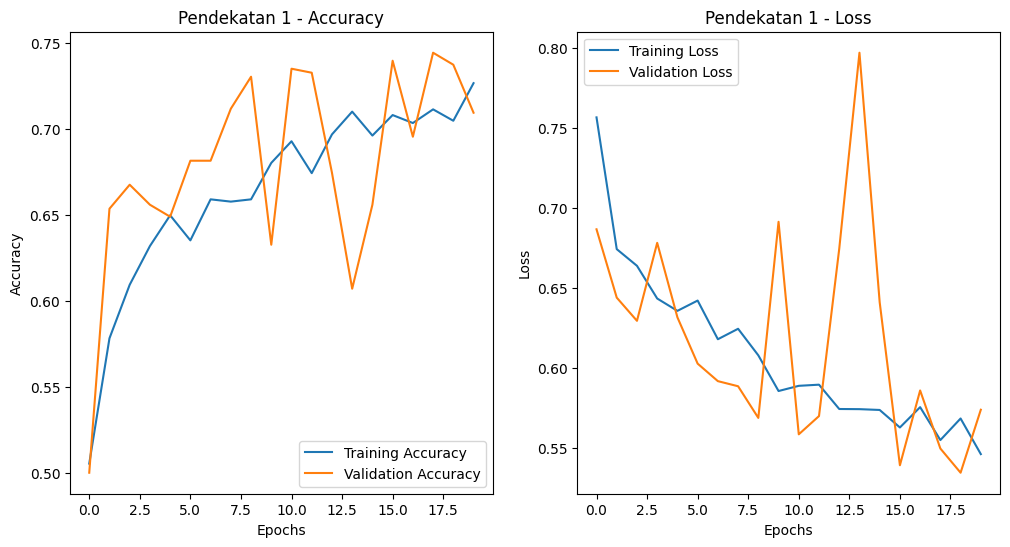

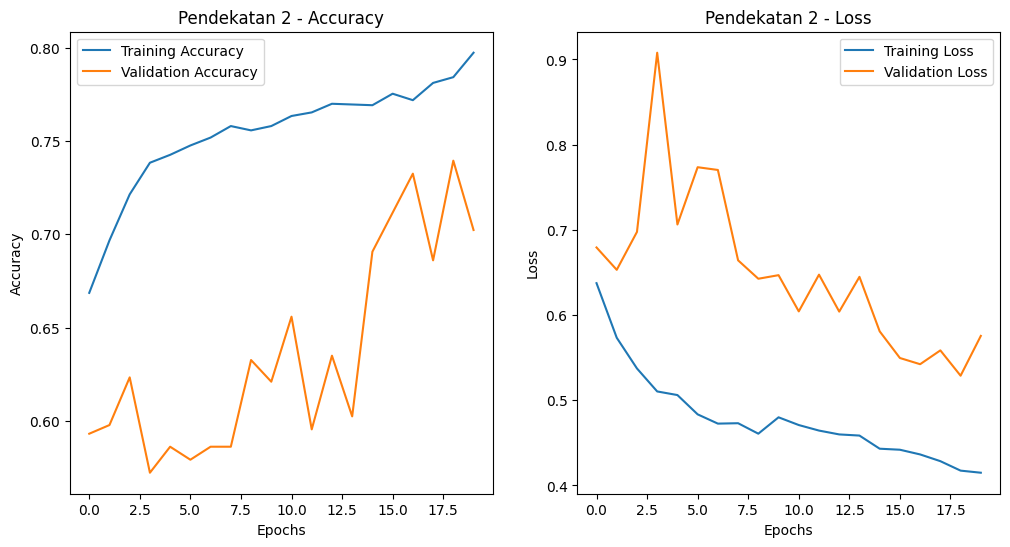

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    # Plot akurasi
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Visualisasi hasil untuk Pendekatan 1
plot_training_history(history_1, "Pendekatan 1")

# Visualisasi hasil untuk Pendekatan 2
plot_training_history(history_2, "Pendekatan 2")

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Prediksi untuk test data
predictions_1 = model_1.predict(test_data_1)
predicted_classes_1 = np.argmax(predictions_1, axis=1)
true_classes_1 = test_data_1.classes

# Classification Report Pendekatan 1
print("Classification Report - Pendekatan 1")
print(classification_report(true_classes_1, predicted_classes_1, target_names=test_data_1.class_indices.keys()))

# Ulangi untuk Pendekatan 2
predictions_2 = model_2.predict(test_data_2)
predicted_classes_2 = np.argmax(predictions_2, axis=1)
true_classes_2 = test_data_2.classes

# Classification Report Pendekatan 2
print("Classification Report - Pendekatan 2")
print(classification_report(true_classes_2, predicted_classes_2, target_names=test_data_2.class_indices.keys()))

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 684ms/step
Classification Report - Pendekatan 1
              precision    recall  f1-score   support

     Baroque       0.85      0.48      0.61       109
   Modernist       0.64      0.92      0.75       109

    accuracy                           0.70       218
   macro avg       0.74      0.70      0.68       218
weighted avg       0.74      0.70      0.68       218

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step
Classification Report - Pendekatan 2
              precision    recall  f1-score   support

     Baroque       0.86      0.50      0.63       109
   Modernist       0.65      0.92      0.76       109

    accuracy                           0.71       218
   macro avg       0.75      0.71      0.69       218
weighted avg       0.75      0.71      0.69       218



# perbaikan model

Found 1510 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.5444 - loss: 1.2222 - val_accuracy: 0.5000 - val_loss: 7.4965
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.6165 - loss: 0.8961 - val_accuracy: 0.5000 - val_loss: 6.7038
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.5958 - loss: 0.8102 - val_accuracy: 0.5000 - val_loss: 8.3900
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6298 - loss: 0.6841 - val_accuracy: 0.5000 - val_loss: 9.1572
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6375 - loss: 0.7013 - val_accuracy: 0.4977 - val_loss: 4.7040
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6775 - loss: 0.6249 - val_accuracy: 0.4767 - val_loss: 4.5243
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7262 - loss: 0.5568 - val_accuracy: 0.4907 - val_loss: 3.3773
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6942 - loss: 0.5936 - val_accuracy: 0.5000 - val_loss: 3.

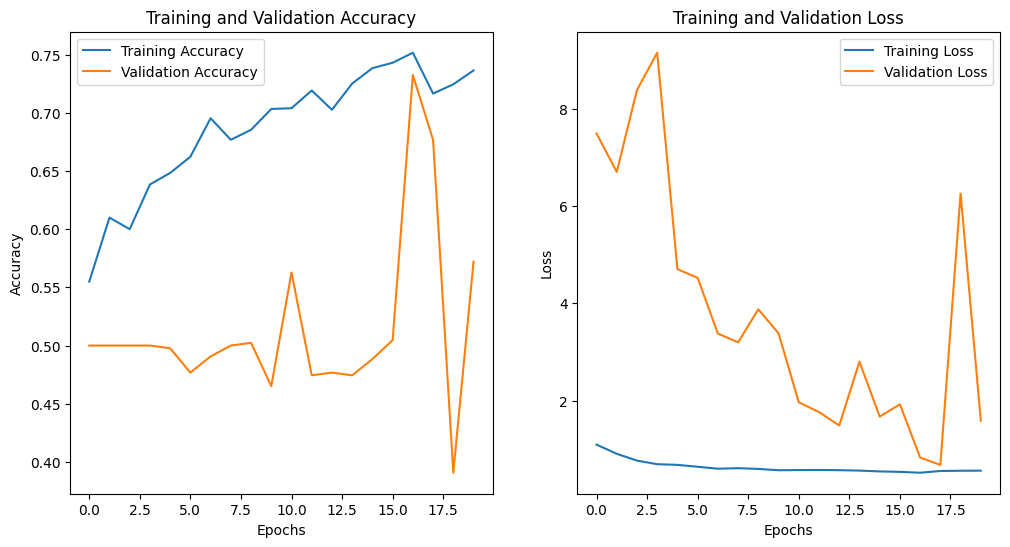

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 708ms/step
Classification Report
              precision    recall  f1-score   support

     Baroque       0.77      0.47      0.58       109
   Modernist       0.62      0.86      0.72       109

    accuracy                           0.67       218
   macro avg       0.70      0.67      0.65       218
weighted avg       0.70      0.67      0.65       218

Confusion Matrix:
 [[51 58]
 [15 94]]


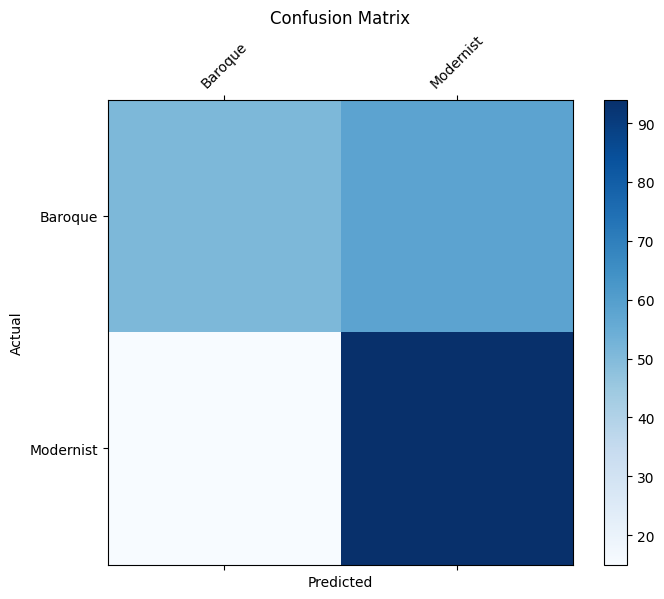

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Augmentasi dan normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,        # Augmentasi tambahan
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,           # Augmentasi tambahan
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/train'
val_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/val'
test_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/test'

# Load dataset (Pendekatan 1)
train_data = train_datagen.flow_from_directory(
    train_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Arsitektur model CNN dengan perbaikan
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),  # Dropout untuk regularisasi

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(256, activation='relu'),  # Tambahan jumlah unit
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')  # 2 kelas
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Buat model
model = create_cnn_model()

# Early stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")

# Visualisasi hasil training
def plot_training_history(history):
    # Akurasi
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

# Classification Report
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap=plt.cm.Blues, fignum=1)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.title('Confusion Matrix')
plt.show()


Found 2592 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 686s 8s/step - accuracy: 0.5465 - loss: 1.2155 - val_accuracy: 0.7070 - val_loss: 0.6259
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 783s 9s/step - accuracy: 0.6555 - loss: 0.9001 - val_accuracy: 0.8047 - val_loss: 0.5245
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 674s 8s/step - accuracy: 0.7072 - loss: 0.7310 - val_accuracy: 0.8395 - val_loss: 0.4457
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 683s 8s/step - accuracy: 0.7476 - loss: 0.6426 - val_accuracy: 0.8488 - val_loss: 0.3805
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 673s 8s/step - accuracy: 0.7469 - loss: 0.6233 - val_accuracy: 0.8349 - val_loss: 0.3543
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 680s 8s/step - accuracy: 0.7565 - loss: 0.6197 - val_accuracy: 0.8442 - val_loss: 0.3356
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 679s 8s/step - accuracy: 0.7870 - loss: 0.5442 - val_accuracy: 0.8465 - val_

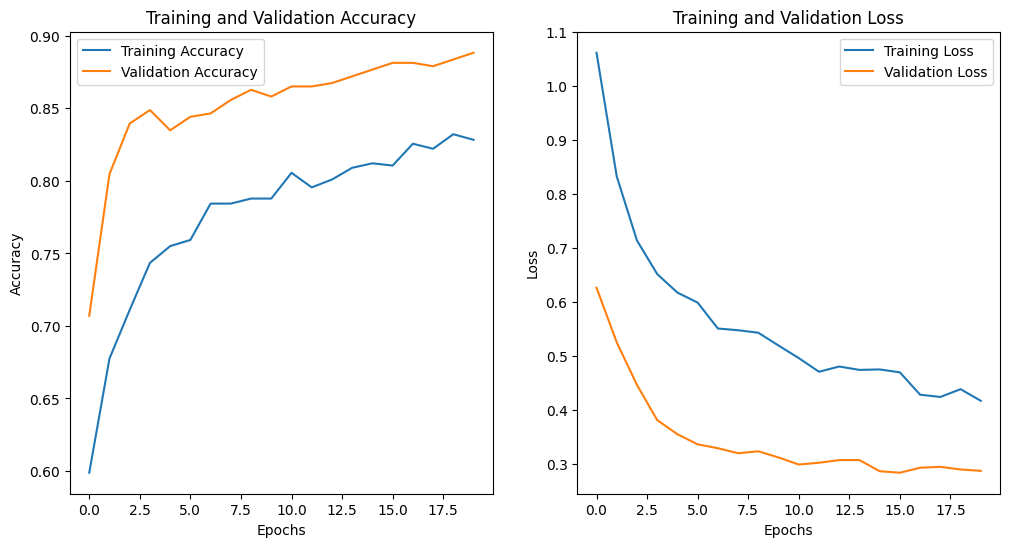

7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step
Classification Report
              precision    recall  f1-score   support

     Baroque       0.86      0.88      0.87       109
   Modernist       0.88      0.86      0.87       109

    accuracy                           0.87       218
   macro avg       0.87      0.87      0.87       218
weighted avg       0.87      0.87      0.87       218

Confusion Matrix:
 [[96 13]
 [15 94]]


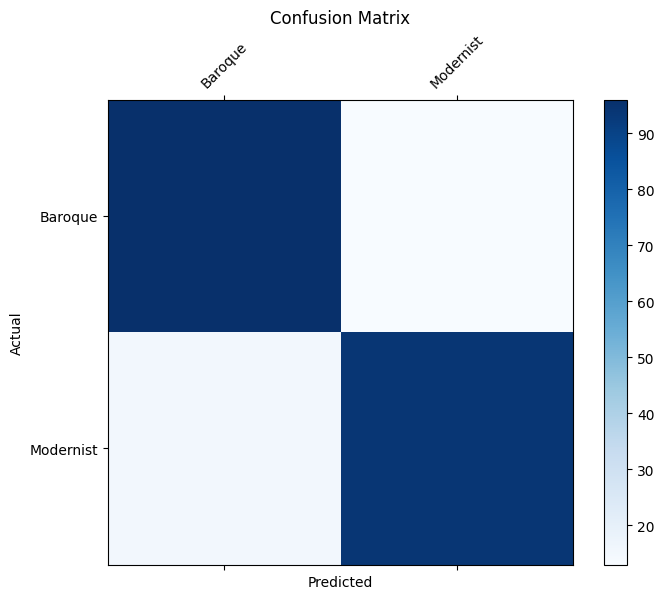

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Augmentasi dan Normalisasi Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset/train'
val_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset/val'
test_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset/test'


# Load dataset
train_data = train_datagen.flow_from_directory(
    train_dir_2,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir_2,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir_2,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Transfer Learning dengan VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze semua layer pretrained
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan baru di atas VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling untuk meratakan fitur
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # Output layer untuk 2 kelas

# Buat model baru
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")

# Visualisasi hasil training
def plot_training_history(history):
    # Akurasi
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

# Classification Report
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap=plt.cm.Blues, fignum=1)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.title('Confusion Matrix')
plt.show()


# ***Tugas Hyperparameter Tuning***

Berdasarkan penggunaan model arsitektur CNN untuk klasifikasi gambar antara gaya arsitektur Baroque dan Modernist yang telah dibuat sebelumnya, akan dilakukan hyperparameter tuning yaitu pencarian kombinasi parameter terbaik dengan tujuan untuk meningkatkan performa dari model.

Memanfaatan hyperparameter tuning tools bernama Optuna, dengan penggunaan model optimasi bayesian (default) yang dianggap lebih efisien daripada model optimasi lainnya. Proses iterasi (trial) menggunakan model probabilistik untuk mencari kombinasi hyperparameter terbaik secara otomatis. Bayesian Optimization adalah proses iteratif, di mana hasil sebelumnya digunakan untuk memperbarui model probabilistik yang memandu pencarian hyperparameter. Dalam Optuna, proses ini dilakukan oleh TPE Sampler secara default.


Definisi nilai hyperparameter yang dioptimasi. Hyperparameter yang dipilih mencakup aspek arsitektur model (jumlah filter, dense units) dan proses pelatihan (dropout rate, learning rate).   

1. Jumlah Filter pada Convolutional Layer, digunakan untuk mengekstraksi fitur dari gambar, seperti tepi, pola, atau tekstur.

    value : [32, 64, 128, 256]
  - 32 filter menangkap pola sederhana seperti garis.
  - 256 filter menangkap pola yang lebih kompleks.

  Menambahkan lebih banyak filter dapat meningkatkan kemampuan representasi, tetapi terlalu banyak filter bisa membuat model menjadi berat dan overfitting.

2. Dropout Rate, teknik regulasi yang secara acak "mematikan" sebagian neuron selama pelatihan untuk mencegah overfitting.

    value : [0.2, 0.3, 0.4, 0.5]

  Dropout membantu model menjadi lebih general dan tidak terlalu bergantung pada pola tertentu di data training. Semakin tinggi dropout (misalnya 0.5), semakin agresif regulasinya. Namun, dropout yang terlalu tinggi bisa menghambat model belajar.

3. Learning Rate, mengontrol kecepatan model memperbarui bobotnya selama training.

    value : [0.0001, 0.001, 0.01] (log scale)

   - Learning rate yang terlalu besar (misalnya 0.01) bisa membuat model melewatkan solusi optimal (oscillation).
   - Learning rate yang terlalu kecil (misalnya 0.0001) membuat model belajar terlalu lambat.

  Skala logaritmik digunakan karena perubahan kecil dalam learning rate dapat memiliki dampak besar.

4. Dense Units pada Fully Connected Layer, jumlah neuron di fully connected layer terakhir sebelum output.

    value : [64, 128, 256]

    - Unit yang lebih kecil (64) mungkin tidak cukup untuk mempelajari pola kompleks.
    - Unit yang besar (256) memberikan kapasitas lebih besar tetapi membutuhkan waktu pelatihan lebih lama.

# Hyperparameter Tuning

In [9]:
# File Pendekatan 1
train_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/train'
val_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/val'
test_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/test'

# # File Pendekata 2
# train_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset/train'
# val_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset/val'
# test_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDataset/test'

In [3]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


Load dataset pendekatan 1 yang akan digunakan untuk hyperparameter tuning

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi dan Normalisasi Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/train'
val_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/val'
test_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedBalancedSampleDataset/test'


# Load dataset
train_data_1 = train_datagen.flow_from_directory(
    train_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data_1 = val_test_datagen.flow_from_directory(
    val_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data_1 = val_test_datagen.flow_from_directory(
    test_dir_1,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1510 images belonging to 2 classes.
Found 430 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [5]:
# install tool hyperparameter tuning optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


# Melakukan beberapa kali percobaan hyperparameter tuning dengan epoch dan trial yang berbeda

# Percobaan 1

Percobaan dengan epoch 20 dan trial 20, namun ouput tidak berhasil selesai karena melebihi batas waktu runtime yang ditentukan colab (<12jam).

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi untuk tuning
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    filters_1 = trial.suggest_categorical("filters_1", [32, 64, 128])
    filters_2 = trial.suggest_categorical("filters_2", [64, 128, 256])
    filters_3 = trial.suggest_categorical("filters_3", [128, 256])
    dropout_1 = trial.suggest_float("dropout_1", 0.2, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0.2, 0.5)
    dropout_3 = trial.suggest_float("dropout_3", 0.3, 0.5)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])
    dropout_fc = trial.suggest_float("dropout_fc", 0.3, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Membuat model
    model = Sequential([
        Conv2D(filters_1, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_1),

        Conv2D(filters_2, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_2),

        Conv2D(filters_3, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_3),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_fc),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callback untuk early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Melatih model
    history = model.fit(
        train_data_1,
        validation_data=val_data_1,
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return akurasi validasi terbaik
    return max(history.history['val_accuracy'])

# Jalankan optimisasi dengan Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Hasil terbaik
print("Best hyperparameters: ", study.best_params)


[I 2024-11-26 13:48:28,052] A new study created in memory with name: no-name-23cc45ae-b70c-421f-8740-eb50dfd97cba
<ipython-input-7-52c15582d78e>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`

best_params_percobaan_1 (value : 0.7511627674102783) = {

    'filters_1': 32,
    'filters_2': 256,
    'filters_3': 128,
    'dropout_1': 0.32532751573694446,
    'dropout_2': 0.29882195165932035,
    'dropout_3': 0.3013246195846167,
    'dense_units': 256,
    'dropout_fc': 0.48673860836425087,
    'learning_rate': 0.0009876664042632666
}

# Percobaan 2

Percobaan dengan epoch 10 dan trial 10

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi untuk tuning
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    filters_1 = trial.suggest_categorical("filters_1", [32, 64, 128])
    filters_2 = trial.suggest_categorical("filters_2", [64, 128, 256])
    filters_3 = trial.suggest_categorical("filters_3", [128, 256])
    dropout_1 = trial.suggest_float("dropout_1", 0.2, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0.2, 0.5)
    dropout_3 = trial.suggest_float("dropout_3", 0.3, 0.5)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])
    dropout_fc = trial.suggest_float("dropout_fc", 0.3, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Membuat model
    model = Sequential([
        Conv2D(filters_1, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_1),

        Conv2D(filters_2, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_2),

        Conv2D(filters_3, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_3),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_fc),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callback untuk early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Melatih model
    history = model.fit(
        train_data_1,
        validation_data=val_data_1,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return akurasi validasi terbaik
    return max(history.history['val_accuracy'])

# Jalankan optimisasi dengan Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Hasil terbaik
print("Best hyperparameters: ", study.best_params)


[I 2024-11-27 03:17:40,324] A new study created in memory with name: no-name-9873fc96-9935-4674-a1ad-711facba5e92
<ipython-input-6-b58350a5333c>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`

Best hyperparameters:  {'filters_1': 64, 'filters_2': 64, 'filters_3': 256, 'dropout_1': 0.22356466191738922, 'dropout_2': 0.2862070590756361, 'dropout_3': 0.4757912062607345, 'dense_units': 128, 'dropout_fc': 0.49506612647209663, 'learning_rate': 0.0009367820444391744}


best_params_percobaan_2 (value : 0.7232558131217957) = {

    'filters_1': 64,
    'filters_2': 64,
    'filters_3': 256,
    'dropout_1': 0.22356466191738922,
    'dropout_2': 0.2862070590756361,
    'dropout_3': 0.4757912062607345,
    'dense_units': 128,
    'dropout_fc': 0.49506612647209663,
    'learning_rate': 0.0009367820444391744
}

# Percobaan 3

Percobaan dengan epoch 10 dan trial 20

In [5]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi untuk tuning
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    filters_1 = trial.suggest_categorical("filters_1", [32, 64, 128])
    filters_2 = trial.suggest_categorical("filters_2", [64, 128, 256])
    filters_3 = trial.suggest_categorical("filters_3", [128, 256])
    dropout_1 = trial.suggest_float("dropout_1", 0.2, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0.2, 0.5)
    dropout_3 = trial.suggest_float("dropout_3", 0.3, 0.5)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])
    dropout_fc = trial.suggest_float("dropout_fc", 0.3, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Membuat model
    model = Sequential([
        Conv2D(filters_1, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_1),

        Conv2D(filters_2, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_2),

        Conv2D(filters_3, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_3),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_fc),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callback untuk early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Melatih model
    history = model.fit(
        train_data_1,
        validation_data=val_data_1,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return akurasi validasi terbaik
    return max(history.history['val_accuracy'])

# Jalankan optimisasi dengan Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Hasil terbaik
print("Best hyperparameters: ", study.best_params)


[I 2024-11-30 00:14:19,076] A new study created in memory with name: no-name-012aebcf-6a75-42af-baa3-d67bbc70af3d
<ipython-input-5-d16df0d60041>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`

Best hyperparameters:  {'filters_1': 64, 'filters_2': 128, 'filters_3': 128, 'dropout_1': 0.37213096633851156, 'dropout_2': 0.24368234299320396, 'dropout_3': 0.37950841664402435, 'dense_units': 128, 'dropout_fc': 0.3612677476399201, 'learning_rate': 0.0003938632128063298}


best_params_percobaan_3 (value : 0.7209302186965942) = {

    'filters_1': 64,
    'filters_2': 128,
    'filters_3': 128,
    'dropout_1': 0.37213096633851156,
    'dropout_2': 0.24368234299320396,
    'dropout_3': 0.37950841664402435,
    'dense_units': 128,
    'dropout_fc': 0.3612677476399201,
    'learning_rate': 0.0003938632128063298
}


# Percobaan 4

Percobaan dengan epoch 5 dan trial 5, ditambah visualisasi grafik tuning setiap trial

[I 2024-11-30 13:36:02,033] A new study created in memory with name: no-name-88608544-06dc-4a4f-ab07-d98ada92894e
<ipython-input-6-b237977b4af7>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`

Best hyperparameters:  {'filters_1': 128, 'filters_2': 128, 'filters_3': 256, 'dropout_1': 0.21832660389002032, 'dropout_2': 0.4647499090678002, 'dropout_3': 0.4835291283560151, 'dense_units': 128, 'dropout_fc': 0.48744245423936466, 'learning_rate': 0.00025811726363947324}


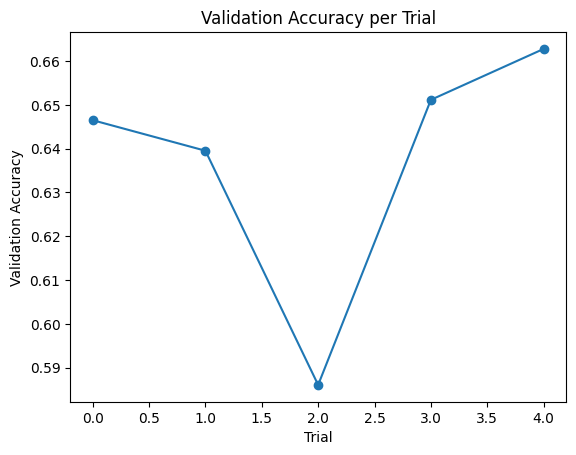

In [6]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi untuk tuning
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    filters_1 = trial.suggest_categorical("filters_1", [32, 64, 128])
    filters_2 = trial.suggest_categorical("filters_2", [64, 128, 256])
    filters_3 = trial.suggest_categorical("filters_3", [128, 256])
    dropout_1 = trial.suggest_float("dropout_1", 0.2, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0.2, 0.5)
    dropout_3 = trial.suggest_float("dropout_3", 0.3, 0.5)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256])
    dropout_fc = trial.suggest_float("dropout_fc", 0.3, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Membuat model
    model = Sequential([
        Conv2D(filters_1, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_1),

        Conv2D(filters_2, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_2),

        Conv2D(filters_3, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_3),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_fc),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callback untuk early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Melatih model
    history = model.fit(
        train_data_1,
        validation_data=val_data_1,
        epochs=5,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return akurasi validasi terbaik
    return max(history.history['val_accuracy'])

# Jalankan optimisasi dengan Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Hasil terbaik
print("Best hyperparameters: ", study.best_params)


import matplotlib.pyplot as plt

# Plot akurasi dari setiap trial
accuracies = [trial.value for trial in study.trials]
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.title("Validation Accuracy per Trial")
plt.xlabel("Trial")
plt.ylabel("Validation Accuracy")
plt.show()

best_params_percobaan_4 (value : 0.6627907156944275) = {

    'filters_1': 128,
    'filters_2': 128,
    'filters_3': 256,
    'dropout_1': 0.21832660389002032,
    'dropout_2': 0.4647499090678002,
    'dropout_3': 0.4835291283560151,
    'dense_units': 2128,
    'dropout_fc': 0.48744245423936466,
    'learning_rate': 0.00025811726363947324
}

# Model dengan Best Hyperparameter

menerapkan paramater terbaik yang ditemukan kedalam model arsitektur CNN yang telah dibuat sebelumnya.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_best_model(best_params):
    model = Sequential([
        # Lapisan konvolusi pertama
        Conv2D(
            best_params['filters_1'],
            (3, 3),
            activation='relu',
            input_shape=(128, 128, 3)
        ),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(best_params['dropout_1']),

        # Lapisan konvolusi kedua
        Conv2D(
            best_params['filters_2'],
            (3, 3),
            activation='relu'
        ),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(best_params['dropout_2']),

        # Lapisan konvolusi ketiga
        Conv2D(
            best_params['filters_3'],
            (3, 3),
            activation='relu'
        ),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(best_params['dropout_3']),

        # Lapisan Fully Connected
        Flatten(),
        Dense(best_params['dense_units'], activation='relu'),
        Dropout(best_params['dropout_fc']),
        Dense(2, activation='softmax')  # Output layer dengan 2 kelas
    ])

    # Kompilasi model dengan learning rate terbaik
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Menginputkan nilai paramater terbaik yang ditemukan hyperparameter tuning kedalam model serta melakukan evaluasi model.

Digunakan parameter terbaik dari percobaan 2 (epoch 10, trial 10).

In [12]:
best_params = {
    'filters_1': 64,
    'filters_2': 64,
    'filters_3': 256,
    'dropout_1': 0.22356466191738922,
    'dropout_2': 0.2862070590756361,
    'dropout_3': 0.4757912062607345,
    'dense_units': 128,
    'dropout_fc': 0.49506612647209663,
    'learning_rate': 0.0009367820444391744
}

best_model = create_best_model(best_params)

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih model
history = best_model.fit(
    train_data_1,
    validation_data=val_data_1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluasi model
test_loss, test_accuracy = best_model.evaluate(test_data_1, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5114 - loss: 0.9070 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5421 - loss: 0.6926 - val_accuracy: 0.5791 - val_loss: 0.6785
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5922 - loss: 0.6719 - val_accuracy: 0.6256 - val_loss: 0.6475
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5976 - loss: 0.6522 - val_accuracy: 0.6884 - val_loss: 0.5950
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6505 - loss: 0.6242 - val_accuracy: 0.6884 - val_loss: 0.6079
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6640 - loss: 0.6234 - val_accuracy: 0.6581 - val_loss: 0.6059
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6511 - loss: 0.6340 - val_accuracy: 0.6163 - val_loss: 0.6977
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6398 - loss: 0.6394 - val_accuracy: 0.7047 - val_loss:

note : pada model tanpa hyperparameter tuning digunakan epoch 20, artinya model ini lebih memiliki cukup waktu untuk belajar pola daripada model dengan hyperparamter tuning yang hanya menggunakan epoch 10. maka belum bisa diberikan kesimpulan bahwa model dengan hyperparameter tuning ini mampu meningkatkan optimasi dari model.

# trash

In [ ]:
# import os
# import numpy as np
# from PIL import Image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import shutil
# from datetime import datetime

# # Path dataset
# original_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/ArchitecturalStylesDataset'
# augmented_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/AugmentedDataset'

# # Membuat direktori baru untuk augmented dataset
# os.makedirs(augmented_dataset_path, exist_ok=True)

# # Augmentasi untuk menyeimbangkan dataset
# augment_gen = ImageDataGenerator(
#     rotation_range=45,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Fungsi untuk augmentasi data
# def augment_data(original_dir, target_dir, target_count):
#     for class_name in os.listdir(original_dir):
#         class_dir = os.path.join(original_dir, class_name)
#         target_class_dir = os.path.join(target_dir, class_name)
#         os.makedirs(target_class_dir, exist_ok=True)

#         images = os.listdir(class_dir)
#         num_images = len(images)

#         # Salin semua data asli
#         for file in images:
#             src = os.path.join(class_dir, file)
#             dst = os.path.join(target_class_dir, file)
#             shutil.copy(src, dst)

#         # Augmentasi jika jumlah data kurang dari target_count
#         if num_images < target_count:
#             required_augments = target_count - num_images
#             image_idx = 0

#             while required_augments > 0:
#                 img_path = os.path.join(class_dir, images[image_idx % num_images])
#                 img = Image.open(img_path)
#                 img = img.resize((128, 128))  # Ubah ukuran gambar ke target input
#                 img = np.expand_dims(np.array(img), 0)

#                 # Augmentasi gambar
#                 for batch in augment_gen.flow(
#                     img,
#                     batch_size=1,
#                     save_to_dir=target_class_dir,
#                     save_prefix=f'aug_{datetime.now().strftime("%Y%m%d%H%M%S")}',
#                     save_format='jpeg'
#                 ):
#                     required_augments -= 1
#                     if required_augments <= 0:
#                         break

#                 image_idx += 1

# # Menyeimbangkan dataset dengan augmentasi
# augment_data(original_dataset_path, augmented_dataset_path, target_count=1867)


In [ ]:
# import os
# import random
# import shutil
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from PIL import Image
# import numpy as np
# from datetime import datetime

# # Path dataset asli
# original_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/ArchitecturalStylesDataset'
# splitted_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/SplittedDatasetAsli'

# # Buat direktori untuk train, val, test
# for split in ['train', 'val', 'test']:
#     for class_name in ['Baroque', 'Modernist']:
#         os.makedirs(os.path.join(splitted_dataset_path, split, class_name), exist_ok=True)

# # Fungsi untuk splitting dataset
# def split_dataset(original_dir, target_dir, train_ratio=0.7, val_ratio=0.2):
#     for class_name in os.listdir(original_dir):
#         class_dir = os.path.join(original_dir, class_name)
#         images = os.listdir(class_dir)

#         # Split data
#         train, test = train_test_split(images, test_size=1 - train_ratio, random_state=42)
#         val, test = train_test_split(test, test_size=(1 - train_ratio - val_ratio) / (1 - train_ratio), random_state=42)

#         # Copy data ke folder target
#         for split, split_name in zip([train, val, test], ['train', 'val', 'test']):
#             target_class_dir = os.path.join(target_dir, split_name, class_name)
#             for file in split:
#                 src = os.path.join(class_dir, file)
#                 dst = os.path.join(target_class_dir, file)
#                 shutil.copy(src, dst)

# # Split dataset asli
# split_dataset(original_dataset_path, splitted_dataset_path)

# # Augmentasi hanya untuk kelas Baroque di training set
# augment_gen = ImageDataGenerator(
#     rotation_range=45,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# def augment_training_data(class_dir, target_count):
#     images = os.listdir(class_dir)
#     num_images = len(images)
#     required_augments = target_count - num_images
#     image_idx = 0

#     while required_augments > 0:
#         img_path = os.path.join(class_dir, images[image_idx % num_images])
#         img = Image.open(img_path)
#         img = img.resize((128, 128))
#         img = np.expand_dims(np.array(img), 0)

#         for batch in augment_gen.flow(
#             img,
#             batch_size=1,
#             save_to_dir=class_dir,
#             save_prefix=f'aug_{datetime.now().strftime("%Y%m%d%H%M%S")}',
#             save_format='jpeg'
#         ):
#             required_augments -= 1
#             if required_augments <= 0:
#                 break
#         image_idx += 1

# # Augmentasi untuk kelas Baroque pada training set
# baroque_train_dir = os.path.join(splitted_dataset_path, 'train', 'Baroque')
# augment_training_data(baroque_train_dir, target_count=1867)


In [ ]:
# # Augmentasi untuk kelas Modernist
# modernist_train_dir = os.path.join(splitted_dataset_path, 'train', 'Modernist')

# # Augmentasi hingga jumlah setara dengan Baroque (1814)
# augment_training_data(modernist_train_dir, target_count=1814)

In [ ]:
# # Verifikasi jumlah gambar setelah augmentasi
# from collections import Counter

# def count_images(directory):
#     return len(os.listdir(directory))

# baroque_train_images_count = count_images(baroque_train_dir)
# print(f"Total images in {baroque_train_dir}: {baroque_train_images_count}")


In [ ]:
# import os
# from PIL import Image

# # Fungsi untuk menghitung jumlah gambar di setiap kelas
# def count_images(directory):
#     class_counts = {}
#     for class_name in os.listdir(directory):
#         class_dir = os.path.join(directory, class_name)
#         if os.path.isdir(class_dir):
#             class_counts[class_name] = len(os.listdir(class_dir))
#     return class_counts

# # Fungsi untuk memvalidasi semua gambar
# def validate_images(directory):
#     invalid_images = []
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             try:
#                 # Membuka gambar untuk memastikan validitasnya
#                 img = Image.open(file_path)
#                 img.verify()  # Memastikan gambar tidak korup
#             except (IOError, SyntaxError):
#                 invalid_images.append(file_path)
#     return invalid_images

# # Path dataset untuk kedua pendekatan
# balanced_sample_path = '/content/drive/MyDrive/Colab Notebooks/Colab_DL/BalancedSampleDataset'


# # Verifikasi jumlah gambar
# balanced_sample_counts = count_images(balanced_sample_path)


# # Validasi gambar
# invalid_balanced_images = validate_images(balanced_sample_path)

# # Hasil Verifikasi
# print("Balanced Sample Dataset Counts:", balanced_sample_counts)
# print("Invalid Images in Balanced Sample Dataset:", invalid_balanced_images)



In [ ]:
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Definisikan model dengan fungsi tuning
# def build_model(hp):
#     model = Sequential()

#     # Lapisan konvolusi pertama
#     model.add(Conv2D(
#         filters=hp.Choice('filters_1', values=[32, 64, 128]),
#         kernel_size=(3, 3),
#         activation='relu',
#         input_shape=(128, 128, 3)
#     ))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(hp.Choice('dropout_1', values=[0.2, 0.3, 0.4])))

#     # Lapisan konvolusi kedua
#     model.add(Conv2D(
#         filters=hp.Choice('filters_2', values=[32, 64, 128]),
#         kernel_size=(3, 3),
#         activation='relu'
#     ))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(hp.Choice('dropout_2', values=[0.2, 0.3, 0.4])))

#     # Lapisan konvolusi ketiga
#     model.add(Conv2D(
#         filters=hp.Choice('filters_3', values=[64, 128, 256]),
#         kernel_size=(3, 3),
#         activation='relu'
#     ))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(hp.Choice('dropout_3', values=[0.3, 0.4, 0.5])))

#     # Fully connected layer
#     model.add(Flatten())
#     model.add(Dense(
#         units=hp.Choice('dense_units', values=[64, 128, 256]),
#         activation='relu'
#     ))
#     model.add(Dropout(hp.Choice('dropout_fc', values=[0.3, 0.4, 0.5])))
#     model.add(Dense(2, activation='softmax'))  # Output layer

#     # Compile model
#     model.compile(
#         optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Membuat objek tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=20,  # Jumlah kombinasi yang akan dicoba
#     directory='tuning_results',
#     project_name='cnn_tuning'
# )

# # Callback untuk early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Melakukan pencarian hyperparameter
# tuner.search(
#     train_data_1,  # Dataset pendekatan 1
#     validation_data=val_data_1,
#     epochs=10,
#     batch_size=32,
#     callbacks=[early_stopping]
# )

In [ ]:
# # Mendapatkan hyperparameter terbaik
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print("Hyperparameter terbaik:")
# print(f"Filters (Layer 1): {best_hps.get('filters_1')}")
# print(f"Filters (Layer 2): {best_hps.get('filters_2')}")
# print(f"Filters (Layer 3): {best_hps.get('filters_3')}")
# print(f"Dropout (Layer 1): {best_hps.get('dropout_1')}")
# print(f"Dropout (Layer 2): {best_hps.get('dropout_2')}")
# print(f"Dropout (Layer 3): {best_hps.get('dropout_3')}")
# print(f"Dropout (Fully Connected): {best_hps.get('dropout_fc')}")
# print(f"Dense Units: {best_hps.get('dense_units')}")
# print(f"Learning Rate: {best_hps.get('learning_rate')}")


In [ ]:
# # Membuat model dengan hyperparameter terbaik
# best_model = tuner.hypermodel.build(best_hps)

# # Melatih ulang model
# history = best_model.fit(
#     train_data_1,
#     validation_data=val_data_1,
#     epochs=20,
#     batch_size=32,
#     callbacks=[early_stopping]
# )

# # Evaluasi pada test data
# test_loss, test_accuracy = best_model.evaluate(test_data_1, verbose=1)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [ ]:
# import matplotlib.pyplot as plt

# # Mendapatkan hasil tuning
# results = tuner.oracle.get_best_trials(num_trials=10)

# # Visualisasi akurasi terbaik
# val_accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in results]

# plt.bar(range(len(val_accuracies)), val_accuracies)
# plt.xlabel('Trial')
# plt.ylabel('Validation Accuracy')
# plt.title('Validation Accuracy of Top Hyperparameter Configurations')
# plt.show()


In [5]:
# import tensorflow as tf
# print("GPU available: ", tf.config.list_physical_devices('GPU'))

GPU available:  []
